# How to Train a Custom Resnet34 for Image Classification in fastai and PyTorch
Can I computer tell the diffence between a daisy and a dandelion? The answer is yes


This tutorial shows you how to train a state of the art image classification model with Resnet, in PyTorch, using the fastai library.

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train Resnet34 image classification model](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train Resnet to recognize your custom classes. We use a [public flowers classification dataset](
https://public.roboflow.com/classification/flowers_classification), which is open source and free to use. You can also use this notebook on your own data.

To train our custom classifier we take the following steps:

* Install fastai dependencies
* Expand our training set via augmentations in Roboflow
* Download custom classificatio data from Roboflow
* Download pretrained Resnet Models
* Run frozen Resent training in fastai
* Find a favorable learning rate
* Run unfrozen training
* Inspect our model's evaluation metrics
* Run Resnet inference on test images
* Export saved Resnet weights for future inference



### **About**

[Roboflow](https://roboflow.ai) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)


# Install fastai dependencies

In [32]:
!pip install fastai

In [33]:
from fastai.vision import *

# Download Custom Classification Data From Roboflow

In [34]:
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="",model_format="folder", notebook="roboflow-resnet")

RuntimeError: API Key is of Incorrect Type 
 Expected Type: <class 'str'>
 Input Type: <class 'NoneType'>

In [36]:
from google.colab import files
kaggle_file = files.upload()  # Chạy xong thì chọn file kaggle.json từ máy bạn


Saving Kaggle Settings.json to Kaggle Settings (1).json


In [37]:
!mkdir -p ~/.kaggle
!cp /content/Kaggle_Settings.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [38]:
!kaggle datasets download -d imsparsh/flowers-dataset --unzip -p /content/flowers_full


Dataset URL: https://www.kaggle.com/datasets/imsparsh/flowers-dataset
License(s): CC0-1.0
 95% 194M/205M [00:00<00:00, 631MB/s]  
100% 205M/205M [00:00<00:00, 663MB/s]


In [40]:
import shutil
from pathlib import Path

source = Path("/content/flowers_full/train")
target = Path("/content/flowers_2class")

# Create the target folder
target.mkdir(parents=True, exist_ok=True)

# Copy only 'daisy' and 'dandelion'
for cls in ["daisy", "dandelion"]:
    shutil.copytree(source/cls, target/cls, dirs_exist_ok=True)

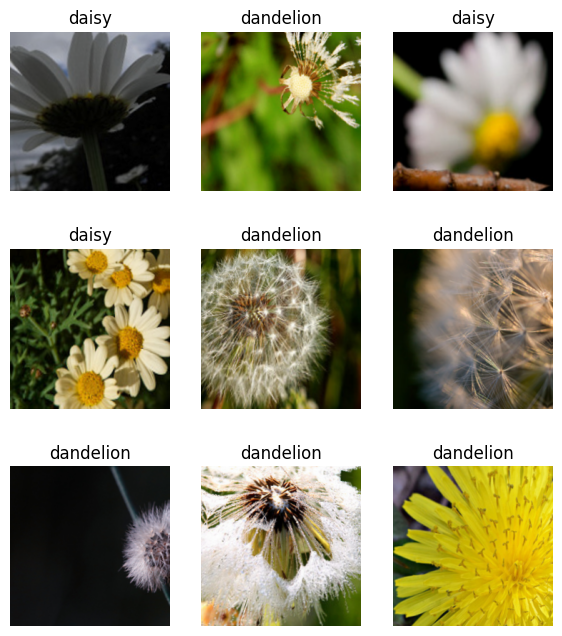

In [42]:
from fastai.vision.all import *

# Create a DataLoaders object from the data in the specified path
path = Path("/content/flowers_2class")
data = ImageDataLoaders.from_folder(path, valid_pct=0.2, item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

# take a peak at the batch to make sure things were loaded correctly
data.show_batch(nrows=3, figsize=(7, 8))

# Set up fastai Resnet model

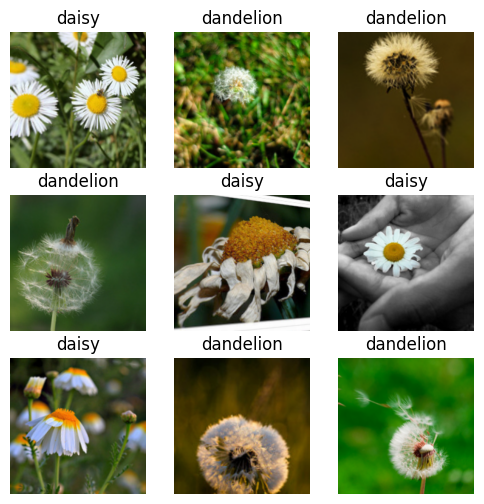

In [43]:
# Point to new 2-class dataset
path = Path("/content/flowers_2class")

# Load into DataLoaders
dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms()
)

# Show sample images
dls.show_batch(max_n=9, figsize=(6, 6))

# Train Custom Resnet Image Classifier

In [44]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.836241,0.201486,0.925764,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.202227,0.198199,0.930131,00:06
1,0.148274,0.125305,0.965065,00:06
2,0.106596,0.163200,0.960699,00:06
3,0.087761,0.168018,0.969432,00:06
4,0.072616,0.154108,0.960699,00:06


In [45]:
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback

early_stop = EarlyStoppingCallback(monitor='accuracy', patience=3)
save_best_model = SaveModelCallback(fname='best_resnet34')


In [ ]:
#frozen training step
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(1, callbacks=[early_stop, save_best_model])

In [ ]:
#load best model from frozen training
learn.load('best_resnet34')


In [ ]:
learn.unfreeze()

In [ ]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()

    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    min_loss_index = np.argmin(losses)


    #loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs

    #return the learning rate that produces the minimum loss divide by 10
    return lrs[min_loss_index] / 10

In [ ]:
optimal_lr = find_appropriate_lr(learn)

In [ ]:
learn.fit_one_cycle(1, max_lr=slice(optimal_lr/10, optimal_lr), callbacks=[early_stop, save_best_model])


In [ ]:
learn.load('best_resnet34')


# Evaluate Classifier Performance

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [ ]:
interp.plot_top_losses(9, figsize=(15,15))


In [ ]:
#run inference on test images
import glob
from IPython.display import Image, display

model = learn.model
model = model.cuda()
for imageName in glob.glob('/content/test/*/*.jpg'):
    print(imageName)
    img = open_image(imageName)
    prediction = learn.predict(img)
    #print(prediction)
    print(prediction[0])
    display(Image(filename=imageName))
    print("\n")

# Save custom classification model for future use

In [ ]:
#model is automatically saved with the "save_best_model" callback
%ls models/

In [ ]:
from google.colab import files
files.download('./models/best_resnet34.pth')